In [1]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from got10k.datasets import GOT10k
from tracker import TrackerSiamFC, SiamFC, DSSiam

from PIL import Image

In [2]:
# Initialize sequence of GOT-10k dataset.
sequence = (522, 'train')

dataset = GOT10k(os.path.expanduser('F:/GOT-10k'), subset=sequence[1], return_meta=False)
dataset = dataset[sequence[0]]

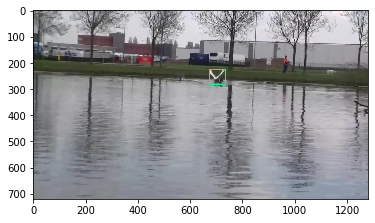

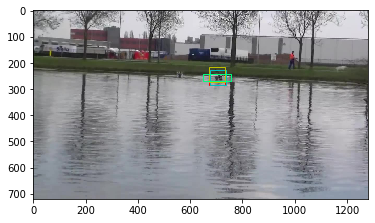

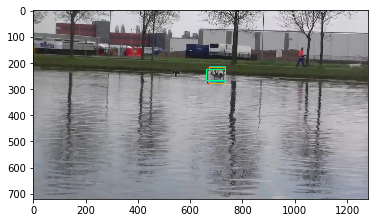

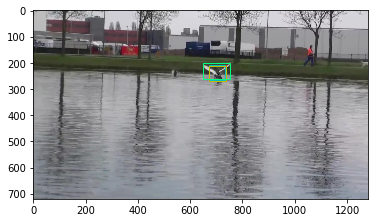

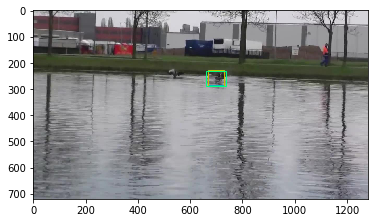

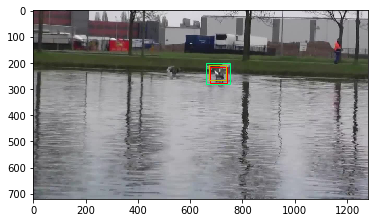

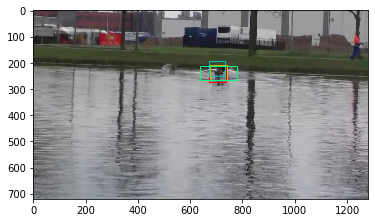

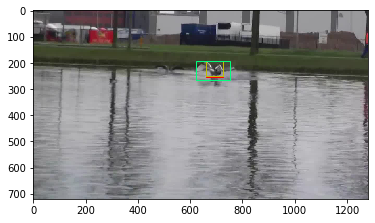

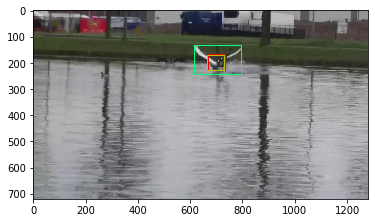

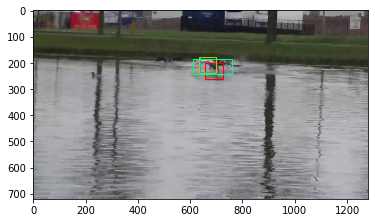

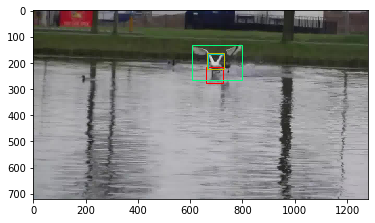

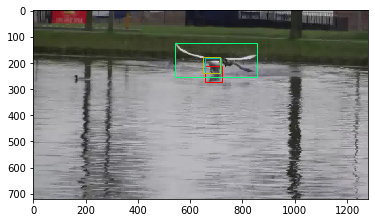

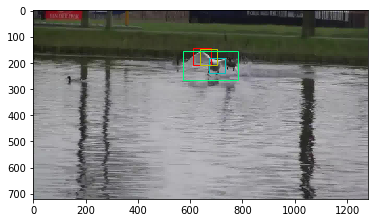

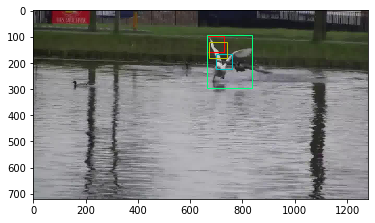

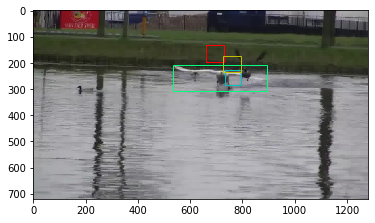

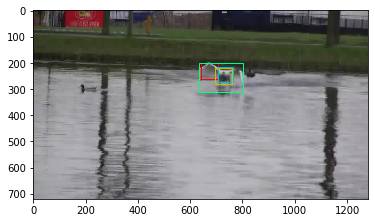

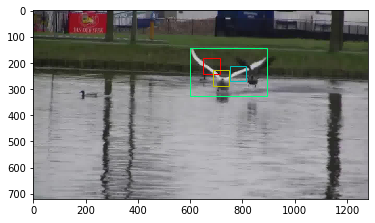

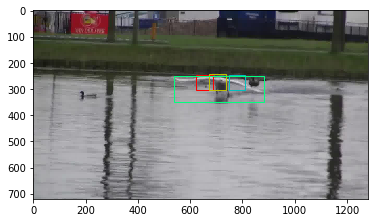

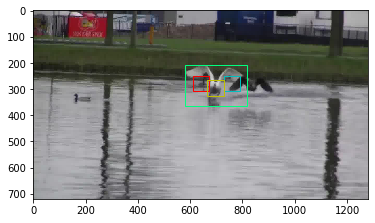

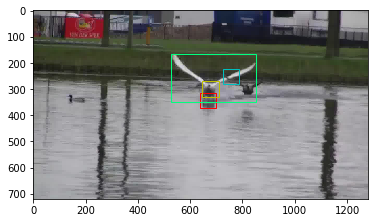

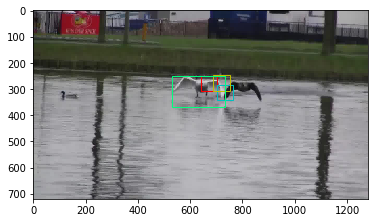

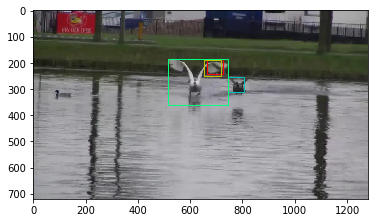

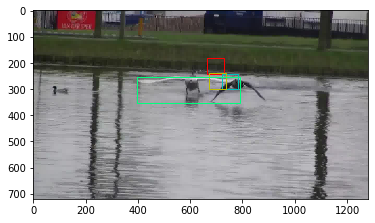

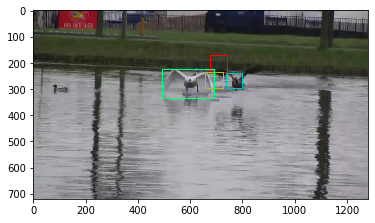

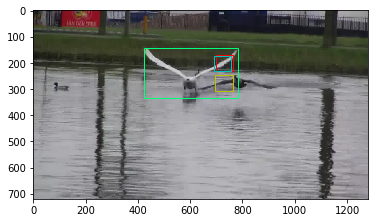

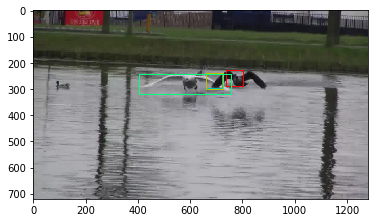

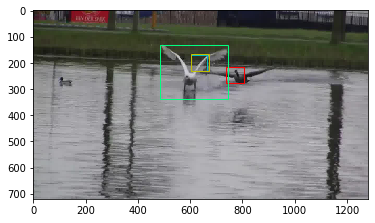

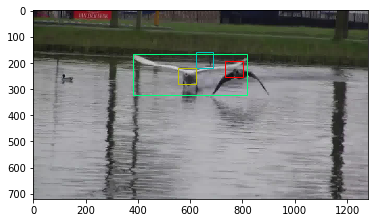

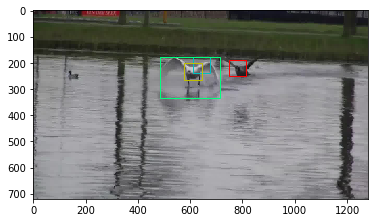

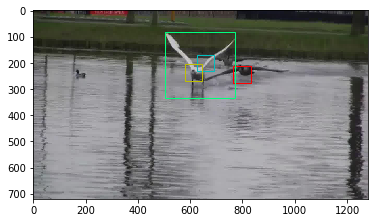

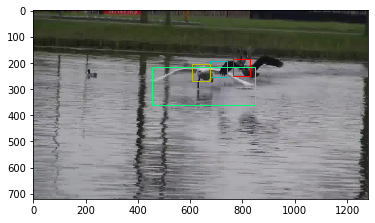

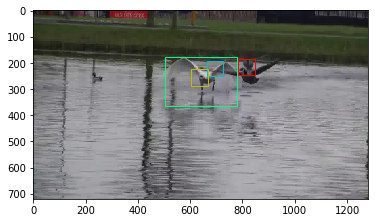

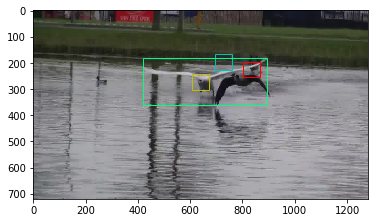

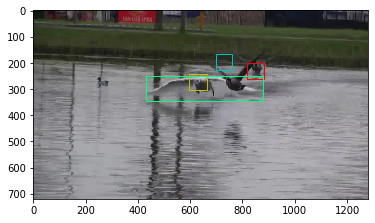

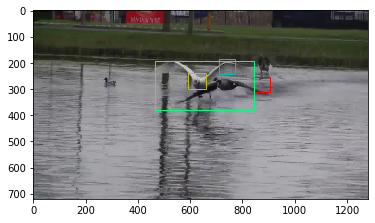

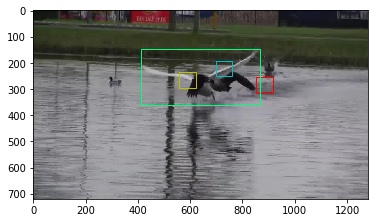

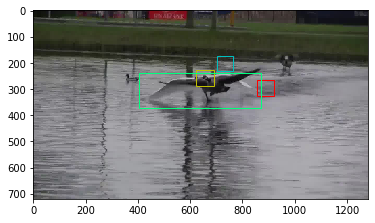

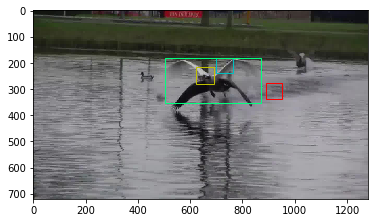

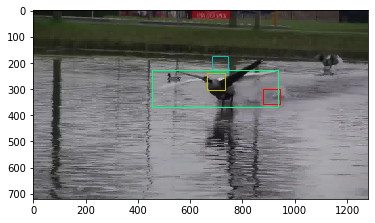

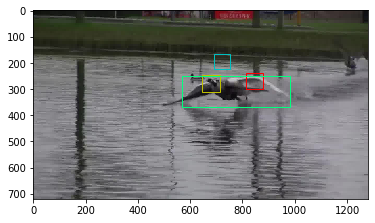

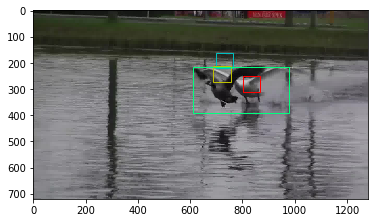

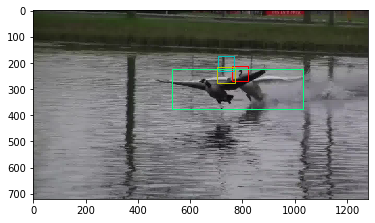

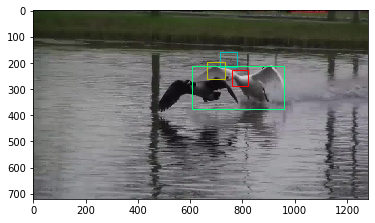

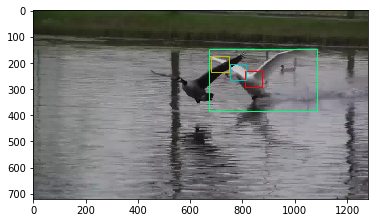

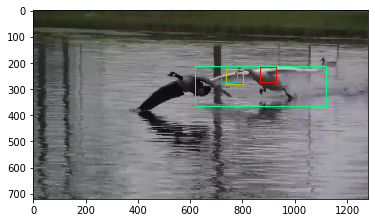

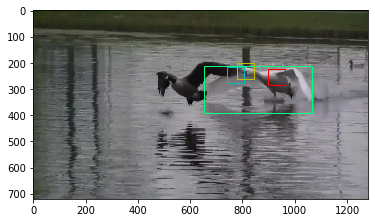

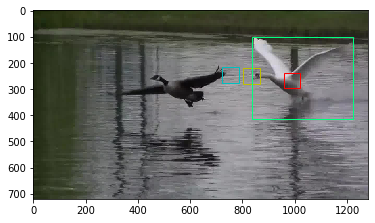

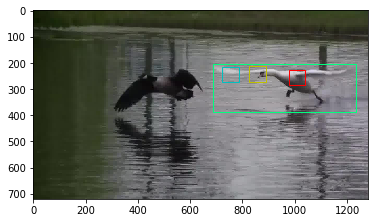

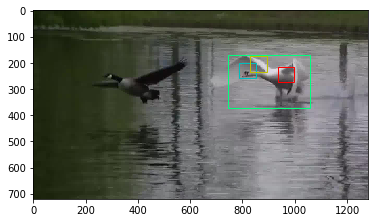

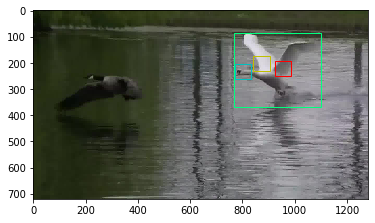

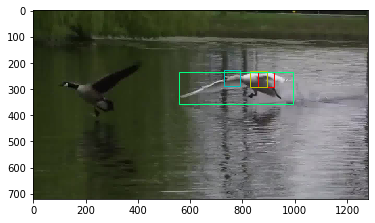

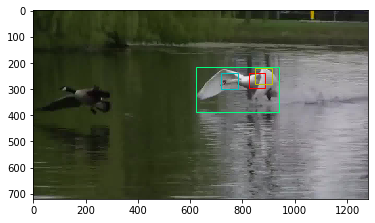

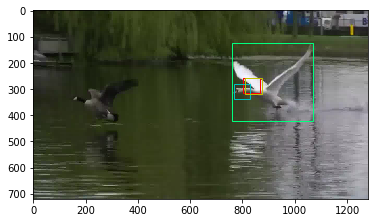

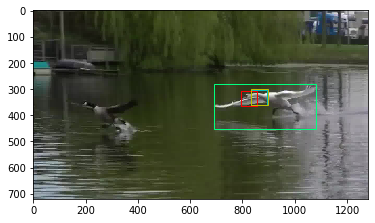

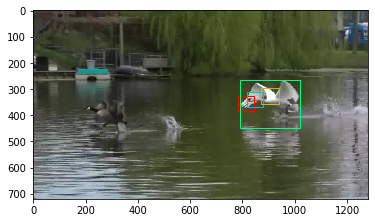

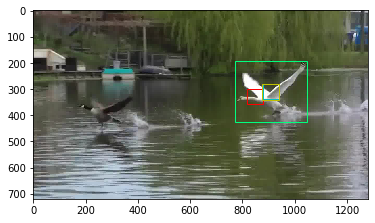

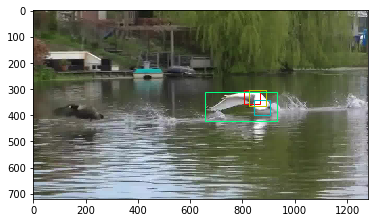

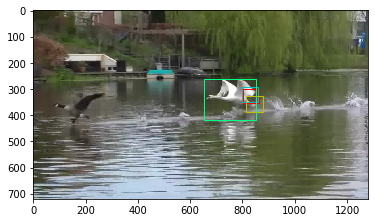

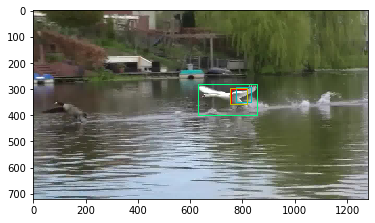

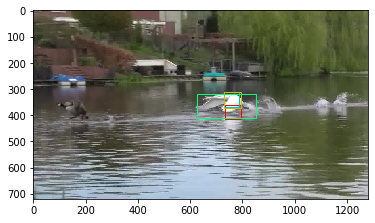

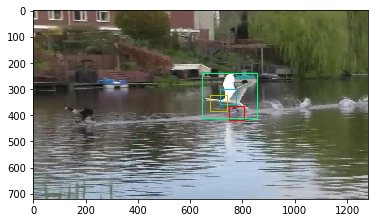

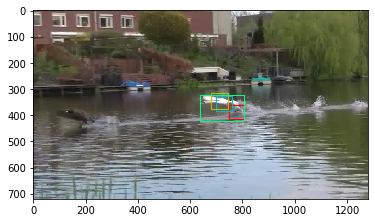

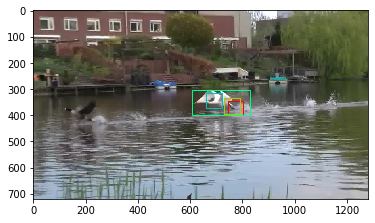

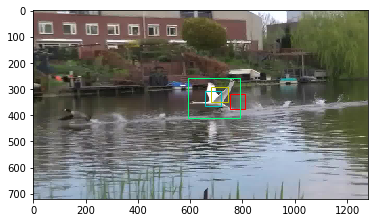

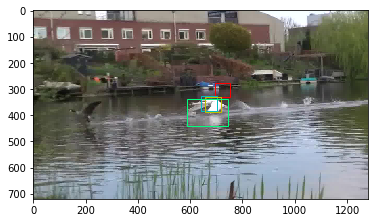

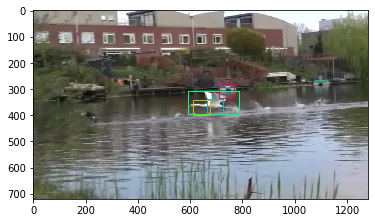

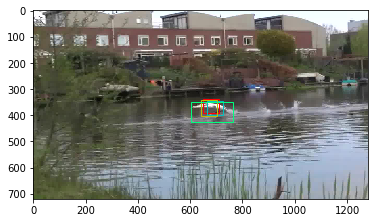

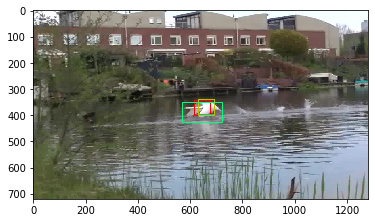

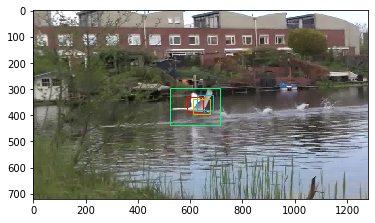

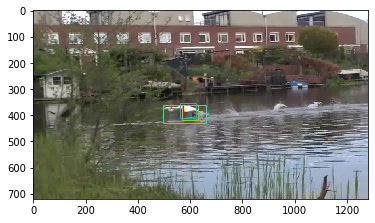

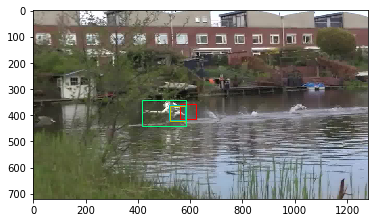

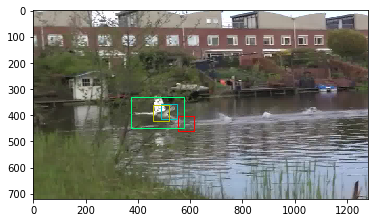

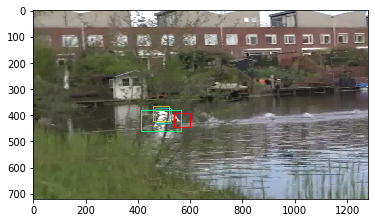

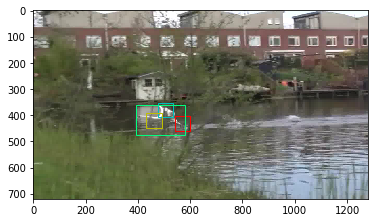

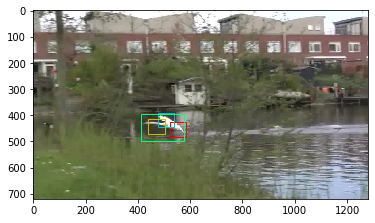

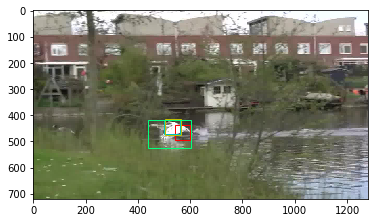

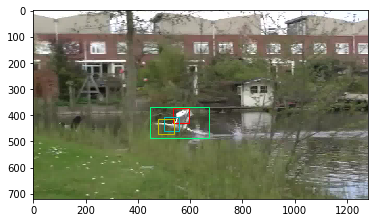

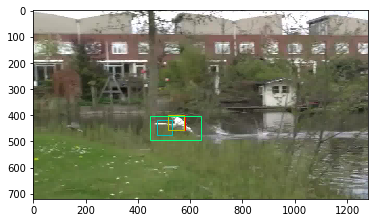

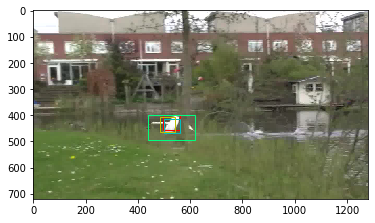

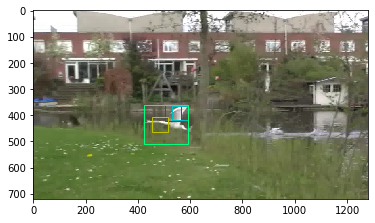

C:/temp/siamfc_522_e10.pth
 AO: 0.13399384310478926
 SR: 0.05
 CE: 80.9251143591398
 Robustness: 0.6625
C:/temp/dssiam_n3_f3_522_e10.pth
 AO: 0.14226711175474813
 SR: 0.0375
 CE: 63.30526482621834
 Robustness: 0.7625
C:/temp/dssiam_n3_gr_522_e10.pth
 AO: 0.15966417498566815
 SR: 0.0375
 CE: 48.59404193154431
 Robustness: 0.8875


In [5]:
from got10k.utils.metrics import center_error, rect_iou

# Model paths and colors.
models = ['C:/temp/siamfc_522_e10.pth', 'C:/temp/dssiam_n3_f3_522_e10.pth', 'C:/temp/dssiam_n3_gr_522_e10.pth']
colors = ['r', 'c', 'y']

# Resulting bounding boxes storage.
box_arr = []

# Data.
img_files, anno = dataset

for m in models:
    # Load model.
    mtype = m.split('/')[-1].split('_')[0]
    backbone = DSSiam(n=1) if mtype == 'dssiam' else SiamFC()
    tracker = TrackerSiamFC(backbone=backbone, net_path=os.path.expanduser(m))
    
    # Track over sequence.

    boxes, _ = tracker.track(img_files, anno[0, :])
    box_arr.append(boxes)

box_arr = np.array(box_arr)

# Show images.
for i in range(box_arr.shape[1]):
    np_img = np.asarray(Image.open(img_files[i]))
    _, ax = plt.subplots()
    ax.imshow(np_img)
    
    # Draw predictions.
    for j in range(box_arr.shape[0]):
        box = box_arr[j][i]
        box = patches.Rectangle(box[:2], *box[2:], linewidth=1, edgecolor=colors[j], facecolor='none')
        ax.add_patch(box)
        
    # Draw ground-truth.
    gt = patches.Rectangle(anno[i][:2], *anno[i][2:], linewidth=1, edgecolor='springgreen', facecolor='none')
    ax.add_patch(gt)
    plt.show()
    
# Report evaluation:
for i, name in enumerate(models):
    ious = rect_iou(box_arr[i], anno)
    ces = center_error(box_arr[i], anno)
    
    print(name)
    print(f" AO: {np.mean(ious)}")
    print(f" SR: {np.mean(ious > .5)}")
    print(f" CE: {np.mean(ces)}")
    print(f" Robustness: {(len(ious) - len(np.where(ious < .05)[0]))/len(ious)}")